# Sensitivity Analysis: Understanding Optimal Solutions

This notebook demonstrates **sensitivity analysis** using LumiX to understand how changes in parameters affect the optimal solution and extract actionable business insights.

## Problem Description

A manufacturing company has solved their production optimization problem and wants to understand:

- **Shadow prices**: Which resources are most valuable?
- **Reduced costs**: Which products are worth increasing?
- **Bottlenecks**: What are the critical constraints?
- **Investment priorities**: Where should we allocate capital?

## Mathematical Background

For a linear program in standard form:

$$\max \mathbf{c}^T \mathbf{x} \quad \text{s.t.} \quad \mathbf{A}\mathbf{x} \leq \mathbf{b}, \; \mathbf{x} \geq 0$$

**Shadow Price** ($\pi_i$): The marginal value of the $i$-th constraint's RHS:
$$\pi_i = \frac{\partial z^*}{\partial b_i}$$

**Reduced Cost** ($\bar{c}_j$): The opportunity cost of forcing variable $x_j$ into the solution:
$$\bar{c}_j = c_j - \sum_i \pi_i a_{ij}$$

## Key Concepts

- **Binding constraints**: Constraints satisfied with equality at optimum
- **Shadow prices**: Marginal value of relaxing a constraint
- **Reduced costs**: Cost of including non-basic variables
- **Bottleneck**: Binding constraint limiting profitability

## 1. Setup and Imports

In [1]:
# Standard library
from dataclasses import dataclass
from typing import List, Dict

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# LumiX
from lumix import (
    LXConstraint,
    LXLinearExpression,
    LXModel,
    LXOptimizer,
    LXSensitivityAnalyzer,
    LXVariable,
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Data Definition

In [2]:
@dataclass
class Product:
    """Product that can be manufactured."""
    id: int
    name: str
    selling_price: float
    unit_cost: float
    labor_hours: float
    machine_hours: float
    material_units: float
    min_production: int


@dataclass
class Resource:
    """Limited resource used in production."""
    id: int
    name: str
    capacity: float


# Sample products
PRODUCTS = [
    Product(1, "Widget A", selling_price=100.0, unit_cost=50.0,
            labor_hours=5.0, machine_hours=3.0, material_units=2.0, min_production=10),
    Product(2, "Widget B", selling_price=150.0, unit_cost=80.0,
            labor_hours=8.0, machine_hours=5.0, material_units=4.0, min_production=5),
    Product(3, "Gadget X", selling_price=200.0, unit_cost=135.0,
            labor_hours=10.0, machine_hours=8.0, material_units=6.0, min_production=8),
    Product(4, "Gadget Y", selling_price=120.0, unit_cost=70.0,
            labor_hours=6.0, machine_hours=4.0, material_units=3.0, min_production=12),
    Product(5, "Premium Z", selling_price=300.0, unit_cost=200.0,
            labor_hours=15.0, machine_hours=12.0, material_units=8.0, min_production=3),
]

# Available resources
RESOURCES = [
    Resource(1, "Labor Hours", capacity=1000.0),
    Resource(2, "Machine Hours", capacity=800.0),
    Resource(3, "Raw Materials", capacity=500.0),
]


def get_resource_usage(product: Product, resource: Resource) -> float:
    """Get resource usage for a product."""
    if resource.name == "Labor Hours":
        return product.labor_hours
    elif resource.name == "Machine Hours":
        return product.machine_hours
    elif resource.name == "Raw Materials":
        return product.material_units
    return 0.0

In [3]:
# Product profitability analysis
prod_data = []
for p in PRODUCTS:
    profit = p.selling_price - p.unit_cost
    profit_per_labor = profit / p.labor_hours
    profit_per_machine = profit / p.machine_hours
    prod_data.append({
        'Product': p.name,
        'Price': f'${p.selling_price:.0f}',
        'Cost': f'${p.unit_cost:.0f}',
        'Profit': f'${profit:.0f}',
        'Profit/Labor': f'${profit_per_labor:.2f}',
        'Profit/Machine': f'${profit_per_machine:.2f}',
        'Min Required': p.min_production
    })

prod_df = pd.DataFrame(prod_data)
print("Product Profitability Analysis:")
display(prod_df.set_index('Product'))

print("\nResource Capacities:")
for r in RESOURCES:
    print(f"  {r.name}: {r.capacity:,.0f} units/week")

Product Profitability Analysis:


,Price,Cost,Profit,Profit/Labor,Profit/Machine,Min Required
Product,,,,,,
Widget A,$100,$50,$50,$10.00,$16.67,10
Widget B,$150,$80,$70,$8.75,$14.00,5
Gadget X,$200,$135,$65,$6.50,$8.12,8
Gadget Y,$120,$70,$50,$8.33,$12.50,12
Premium Z,$300,$200,$100,$6.67,$8.33,3



Resource Capacities:
  Labor Hours: 1,000 units/week
  Machine Hours: 800 units/week
  Raw Materials: 500 units/week


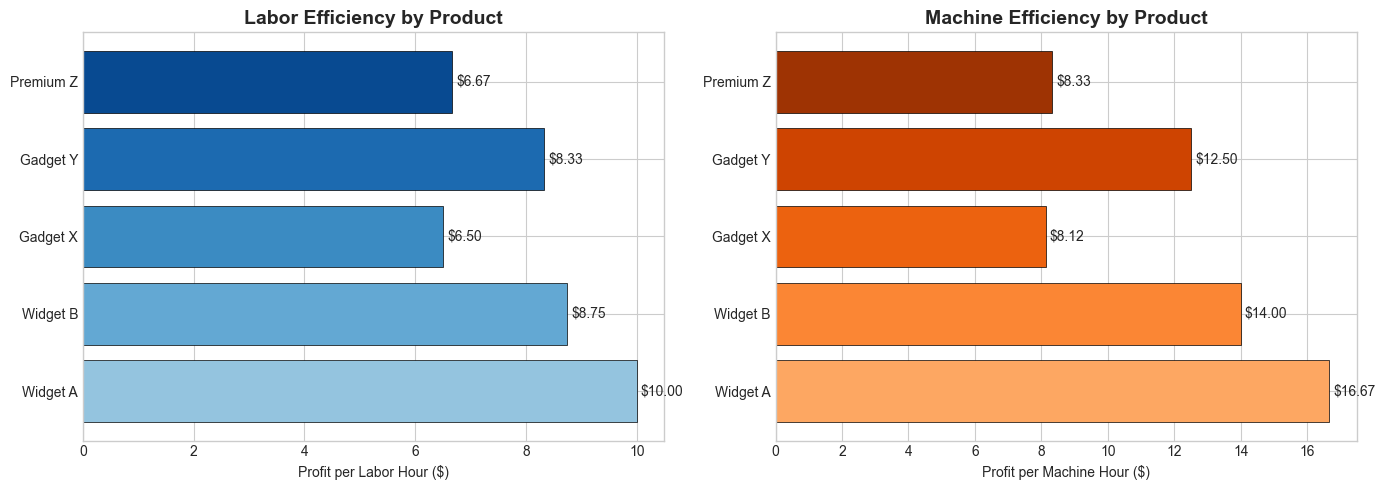

In [4]:
# Resource efficiency visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

products = [p.name for p in PRODUCTS]
profits = [p.selling_price - p.unit_cost for p in PRODUCTS]
labor_eff = [profits[i] / PRODUCTS[i].labor_hours for i in range(len(PRODUCTS))]
machine_eff = [profits[i] / PRODUCTS[i].machine_hours for i in range(len(PRODUCTS))]

# Profit per labor hour
ax1 = axes[0]
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(products)))
bars1 = ax1.barh(products, labor_eff, color=colors, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Profit per Labor Hour ($)')
ax1.set_title('Labor Efficiency by Product', fontsize=14, fontweight='bold')
ax1.bar_label(bars1, fmt='$%.2f', padding=3)

# Profit per machine hour
ax2 = axes[1]
colors2 = plt.cm.Oranges(np.linspace(0.4, 0.9, len(products)))
bars2 = ax2.barh(products, machine_eff, color=colors2, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Profit per Machine Hour ($)')
ax2.set_title('Machine Efficiency by Product', fontsize=14, fontweight='bold')
ax2.bar_label(bars2, fmt='$%.2f', padding=3)

plt.tight_layout()
plt.show()

## 3. Build and Solve Model

In [5]:
def build_production_model() -> LXModel:
    """
    Build production planning model for sensitivity analysis.
    """
    # Decision Variable: Production quantity
    production = (
        LXVariable[Product, float]("production")
        .continuous()
        .bounds(lower=0)
        .indexed_by(lambda p: p.id)
        .from_data(PRODUCTS)
    )

    model = LXModel[Product]("production_planning").add_variable(production)

    # Objective: Maximize profit
    profit_expr = LXLinearExpression[Product]().add_term(
        production, coeff=lambda p: p.selling_price - p.unit_cost
    )
    model.maximize(profit_expr)

    # Constraints: Resource capacity
    for resource in RESOURCES:
        usage_expr = LXLinearExpression().add_term(
            production, coeff=lambda p, r=resource: get_resource_usage(p, r)
        )
        model.add_constraint(
            LXConstraint(f"capacity_{resource.name}")
            .expression(usage_expr)
            .le()
            .rhs(resource.capacity)
        )

    # Constraints: Minimum production
    model.add_constraint(
        LXConstraint[Product]("min_production")
        .expression(LXLinearExpression[Product]().add_term(production, 1.0))
        .ge()
        .rhs(lambda p: float(p.min_production))
        .from_data(PRODUCTS)
        .indexed_by(lambda p: p.name)
    )

    return model


model = build_production_model()
print("Model Summary:")
print(model.summary())

Model Summary:
LXModel: production_planning
  Variable Families: 1
  Constraint Families: 4
  Objective: max



In [6]:
# Solve with sensitivity analysis enabled
optimizer = LXOptimizer().use_solver("ortools").enable_sensitivity()
solution = optimizer.solve(model)

print(f"\nSolution Status: {solution.status}")
print(f"Optimal Profit: ${solution.objective_value:,.2f}")
print(f"Solve Time: {solution.solve_time:.3f}s")

2025-12-12 17:09:04 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:09:04 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:09:04 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 9400.0000 | Time: 0.00s



Solution Status: optimal
Optimal Profit: $9,400.00
Solve Time: 0.000s


In [7]:
# Display optimal production plan
plan_data = []
total_profit = 0

for p in PRODUCTS:
    # Get production quantity
    qty = 0
    for key, val in solution.variables.items():
        if 'production' in key and str(p.id) in key:
            qty = val
            break
    
    profit = (p.selling_price - p.unit_cost) * qty
    total_profit += profit
    
    plan_data.append({
        'Product': p.name,
        'Min Required': p.min_production,
        'Optimal Qty': qty,
        'Unit Profit': p.selling_price - p.unit_cost,
        'Total Profit': profit,
        'Labor Used': qty * p.labor_hours,
        'Machine Used': qty * p.machine_hours
    })

plan_df = pd.DataFrame(plan_data)
print("\nOptimal Production Plan:")
display(plan_df.set_index('Product').round(2))

print(f"\nTotal Profit: ${total_profit:,.2f}")


Optimal Production Plan:


,Min Required,Optimal Qty,Unit Profit,Total Profit,Labor Used,Machine Used
Product,,,,,,
Widget A,10,0,50.0,0.0,0.0,0.0
Widget B,5,0,70.0,0.0,0.0,0.0
Gadget X,8,0,65.0,0.0,0.0,0.0
Gadget Y,12,0,50.0,0.0,0.0,0.0
Premium Z,3,0,100.0,0.0,0.0,0.0



Total Profit: $0.00


## 4. Sensitivity Analysis

In [8]:
# Create sensitivity analyzer
analyzer = LXSensitivityAnalyzer(model, solution)

# Generate comprehensive report
print("="*60)
print("COMPREHENSIVE SENSITIVITY REPORT")
print("="*60)
print(analyzer.generate_report(include_variables=True, include_constraints=True))

COMPREHENSIVE SENSITIVITY REPORT
Sensitivity Analysis Report

Model: production_planning
Objective Value: 9,400.00
Status: optimal
Solve Time: 0.000s

Constraint Sensitivity (Shadow Prices)

Constraint                        Shadow Price       Status
--------------------------------------------------------------------------------
capacity_Labor Hours                 10.000000      Binding
capacity_Machine Hours                0.000000  Non-binding
capacity_Raw Materials                0.000000  Non-binding
min_production                        0.000000  Non-binding

Interpretation:
  • Shadow price = marginal value of relaxing constraint by 1 unit
  • Positive = relaxing increases objective (for maximization)
  • Binding = constraint is tight at optimum

Variable Sensitivity (Reduced Costs)

Variable                                 Value    Reduced Cost       Status
--------------------------------------------------------------------------------
production                          152.

## 5. Shadow Price Analysis

In [9]:
# Analyze shadow prices for resource constraints
shadow_prices = []

for resource in RESOURCES:
    constraint_name = f"capacity_{resource.name}"
    sens = analyzer.analyze_constraint(constraint_name)
    
    shadow_prices.append({
        'Resource': resource.name,
        'Capacity': resource.capacity,
        'Shadow Price': sens.shadow_price if sens.shadow_price else 0,
        'Binding': 'YES' if sens.is_binding else 'NO'
    })

shadow_df = pd.DataFrame(shadow_prices)
print("Shadow Prices (Marginal Value of Resources):")
display(shadow_df.set_index('Resource'))

print("\nInterpretation:")
for row in shadow_prices:
    if row['Shadow Price'] > 0:
        print(f"  - Each additional {row['Resource'].lower()} increases profit by ${row['Shadow Price']:.2f}")

Shadow Prices (Marginal Value of Resources):


,Capacity,Shadow Price,Binding
Resource,,,
Labor Hours,1000.0,10.0,YES
Machine Hours,800.0,0.0,NO
Raw Materials,500.0,0.0,NO



Interpretation:
  - Each additional labor hours increases profit by $10.00


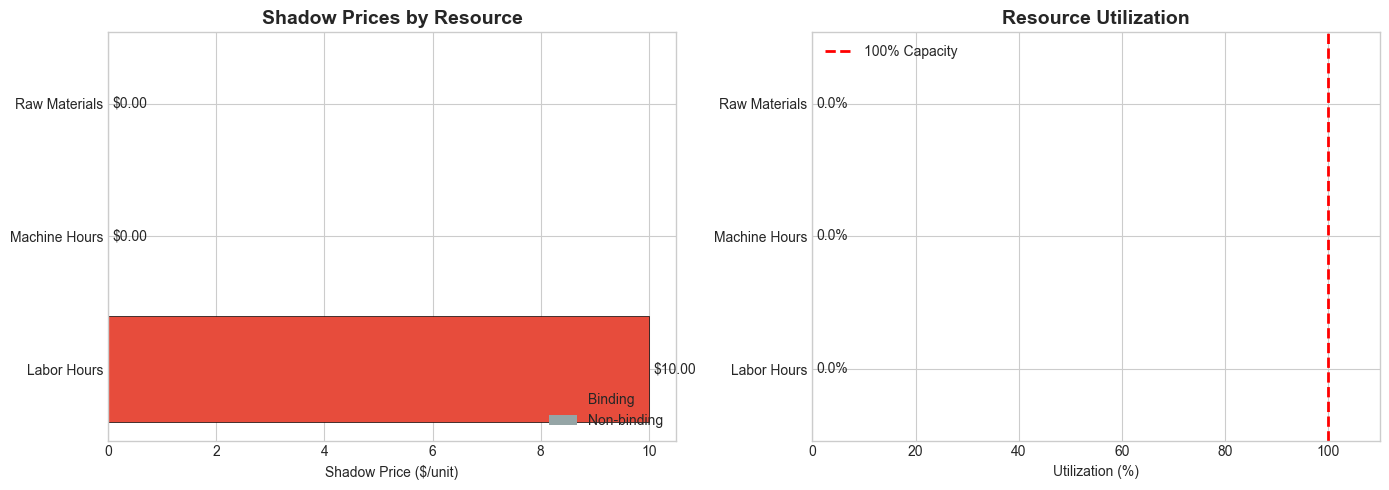

In [10]:
# Visualize shadow prices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

resources = [r['Resource'] for r in shadow_prices]
prices = [r['Shadow Price'] for r in shadow_prices]
binding = [r['Binding'] == 'YES' for r in shadow_prices]

# Shadow price bar chart
ax1 = axes[0]
colors = ['#e74c3c' if b else '#95a5a6' for b in binding]
bars = ax1.barh(resources, prices, color=colors, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Shadow Price ($/unit)')
ax1.set_title('Shadow Prices by Resource', fontsize=14, fontweight='bold')
ax1.bar_label(bars, fmt='$%.2f', padding=3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', label='Binding'),
                   Patch(facecolor='#95a5a6', label='Non-binding')]
ax1.legend(handles=legend_elements, loc='lower right')

# Resource utilization
ax2 = axes[1]
capacities = [r.capacity for r in RESOURCES]
# Calculate usage from solution
usage = []
for r in RESOURCES:
    total_usage = 0
    for p in PRODUCTS:
        qty = 0
        for key, val in solution.variables.items():
            if 'production' in key and str(p.id) in key:
                qty = val
                break
        total_usage += qty * get_resource_usage(p, r)
    usage.append(total_usage)

utilization = [u/c*100 for u, c in zip(usage, capacities)]

bars2 = ax2.barh(resources, utilization, color='#3498db', edgecolor='black', linewidth=0.5)
ax2.axvline(x=100, color='red', linestyle='--', linewidth=2, label='100% Capacity')
ax2.set_xlabel('Utilization (%)')
ax2.set_title('Resource Utilization', fontsize=14, fontweight='bold')
ax2.bar_label(bars2, fmt='%.1f%%', padding=3)
ax2.set_xlim(0, 110)
ax2.legend()

plt.tight_layout()
plt.show()

## 6. Bottleneck Identification

In [11]:
# Identify bottlenecks (binding constraints with high shadow prices)
bottlenecks = analyzer.identify_bottlenecks(shadow_price_threshold=0.01)

print("Bottleneck Analysis:")
print("="*60)

if bottlenecks:
    print(f"\nIdentified {len(bottlenecks)} bottleneck(s):")
    for name in bottlenecks:
        sens = analyzer.analyze_constraint(name)
        resource_name = name.replace('capacity_', '')
        print(f"\n  {resource_name}:")
        print(f"    Shadow Price: ${sens.shadow_price:.4f}")
        print(f"    Impact: Relaxing by 1 unit → +${sens.shadow_price:.2f} profit")
        print(f"    Status: Operating at full capacity")
else:
    print("\nNo significant bottlenecks identified.")

Bottleneck Analysis:

Identified 1 bottleneck(s):

  Labor Hours:
    Shadow Price: $10.0000
    Impact: Relaxing by 1 unit → +$10.00 profit
    Status: Operating at full capacity


In [12]:
# Top sensitive constraints ranking
top_constraints = analyzer.get_most_sensitive_constraints(top_n=5)

print("\nTop 5 Most Valuable Constraints to Relax:")
print("="*60)

ranking_data = []
for i, (name, sens) in enumerate(top_constraints, 1):
    ranking_data.append({
        'Rank': i,
        'Constraint': name.replace('capacity_', '').replace('min_production_', 'Min: '),
        'Shadow Price': f'${sens.shadow_price:.4f}' if sens.shadow_price else '$0.00',
        'Binding': 'YES' if sens.is_binding else 'NO',
        'Expected ROI': f'${sens.shadow_price:.2f}/unit' if sens.shadow_price else 'N/A'
    })

ranking_df = pd.DataFrame(ranking_data)
display(ranking_df.set_index('Rank'))


Top 5 Most Valuable Constraints to Relax:


,Constraint,Shadow Price,Binding,Expected ROI
Rank,,,,
1,Labor Hours,$10.0000,YES,$10.00/unit
2,Machine Hours,$0.00,NO,N/A
3,Raw Materials,$0.00,NO,N/A


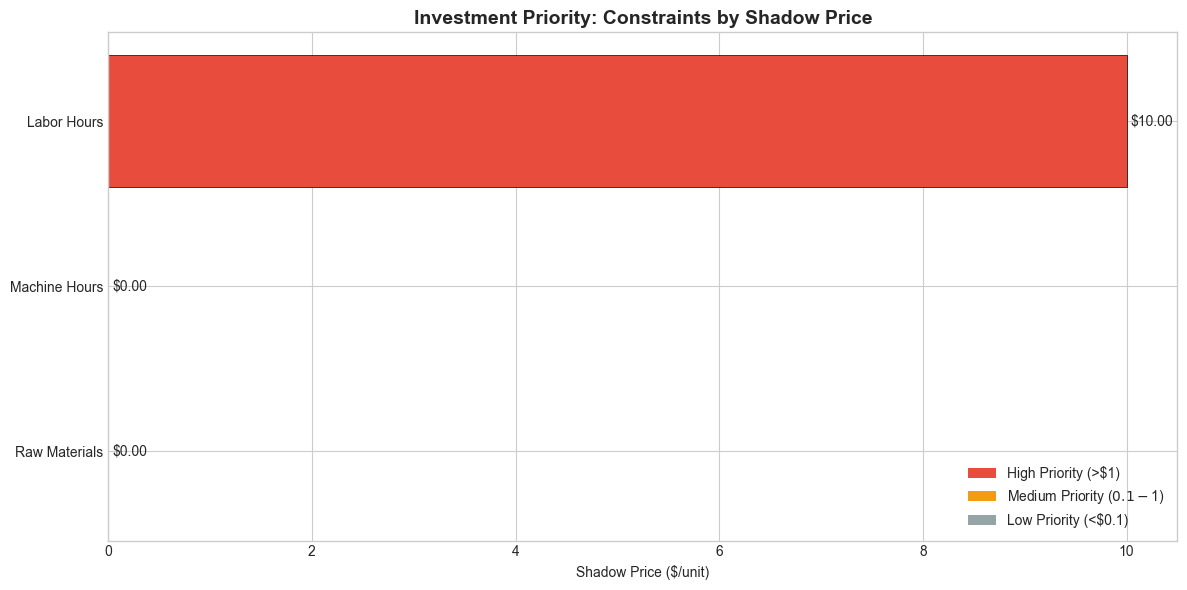

In [13]:
# Investment priority visualization
fig, ax = plt.subplots(figsize=(12, 6))

constraint_names = [name.replace('capacity_', '').replace('min_production_', 'Min: ') 
                    for name, _ in top_constraints[:5]]
shadow_values = [sens.shadow_price if sens.shadow_price else 0 
                 for _, sens in top_constraints[:5]]

# Color by priority
colors = []
for val in shadow_values:
    if val > 1.0:
        colors.append('#e74c3c')  # High priority
    elif val > 0.1:
        colors.append('#f39c12')  # Medium priority
    else:
        colors.append('#95a5a6')  # Low priority

bars = ax.barh(constraint_names[::-1], shadow_values[::-1], color=colors[::-1], 
               edgecolor='black', linewidth=0.5)
ax.set_xlabel('Shadow Price ($/unit)')
ax.set_title('Investment Priority: Constraints by Shadow Price', fontsize=14, fontweight='bold')
ax.bar_label(bars, fmt='$%.2f', padding=3)

# Legend
legend_elements = [
    Patch(facecolor='#e74c3c', label='High Priority (>$1)'),
    Patch(facecolor='#f39c12', label='Medium Priority ($0.1-$1)'),
    Patch(facecolor='#95a5a6', label='Low Priority (<$0.1)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

## 7. ROI Analysis for Capacity Expansion

In [14]:
# ROI waterfall for capacity investments
def calculate_expansion_roi(analyzer, resources, expansion_amount=100):
    """
    Calculate ROI for expanding each resource by a fixed amount.
    """
    roi_data = []
    
    for r in resources:
        constraint_name = f"capacity_{r.name}"
        sens = analyzer.analyze_constraint(constraint_name)
        
        shadow_price = sens.shadow_price if sens.shadow_price else 0
        profit_increase = shadow_price * expansion_amount
        
        roi_data.append({
            'Resource': r.name,
            'Current Capacity': r.capacity,
            'Expansion': expansion_amount,
            'Shadow Price': shadow_price,
            'Profit Increase': profit_increase,
            'Binding': sens.is_binding
        })
    
    return pd.DataFrame(roi_data)


roi_df = calculate_expansion_roi(analyzer, RESOURCES, expansion_amount=100)
print(f"ROI Analysis: Expanding Each Resource by 100 Units")
print("="*60)
display(roi_df.set_index('Resource').round(2))

ROI Analysis: Expanding Each Resource by 100 Units


,Current Capacity,Expansion,Shadow Price,Profit Increase,Binding
Resource,,,,,
Labor Hours,1000.0,100,10.0,1000.0,True
Machine Hours,800.0,100,0.0,0.0,False
Raw Materials,500.0,100,0.0,0.0,False


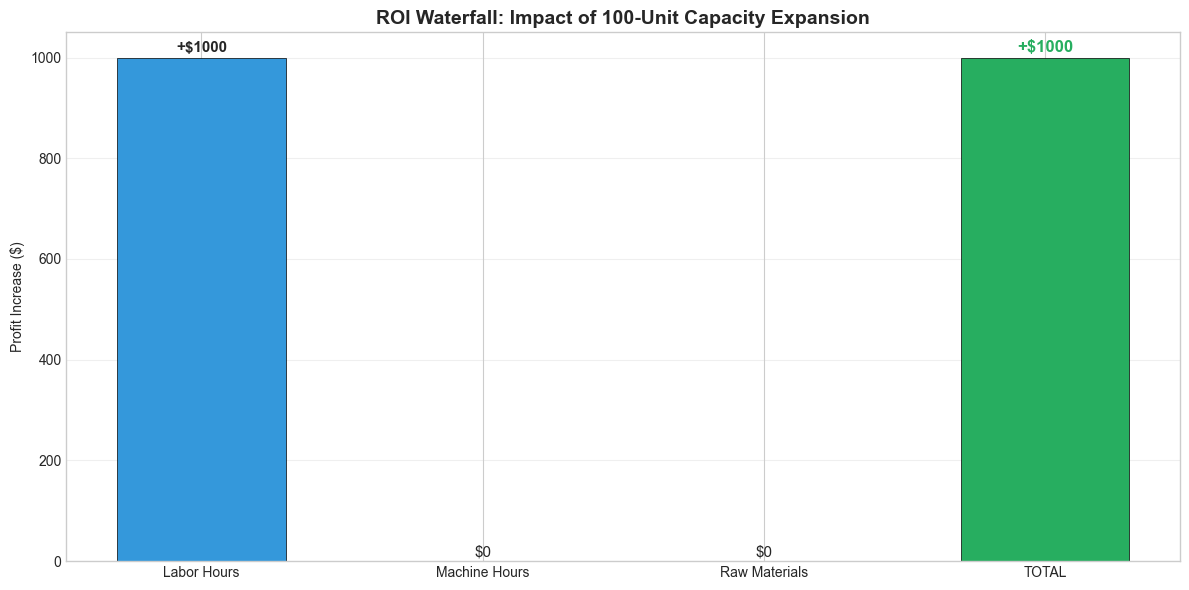

In [15]:
# ROI waterfall visualization
fig, ax = plt.subplots(figsize=(12, 6))

resources = roi_df['Resource'].values
profits = roi_df['Profit Increase'].values

# Cumulative for waterfall
cumulative = np.cumsum(profits)
total = cumulative[-1]

# Create waterfall
x = np.arange(len(resources) + 1)
widths = 0.6

# Individual bars
colors = ['#3498db' if p > 0 else '#95a5a6' for p in profits]
ax.bar(x[:-1], profits, width=widths, color=colors, edgecolor='black', linewidth=0.5)

# Total bar
ax.bar(x[-1], total, width=widths, color='#27ae60', edgecolor='black', linewidth=0.5)

# Labels
ax.set_xticks(x)
ax.set_xticklabels(list(resources) + ['TOTAL'])
ax.set_ylabel('Profit Increase ($)')
ax.set_title('ROI Waterfall: Impact of 100-Unit Capacity Expansion', fontsize=14, fontweight='bold')

# Add value labels
for i, (r, p) in enumerate(zip(resources, profits)):
    if p > 0:
        ax.text(i, p + 10, f'+${p:.0f}', ha='center', fontsize=11, fontweight='bold')
    else:
        ax.text(i, 10, f'${p:.0f}', ha='center', fontsize=11)

ax.text(len(resources), total + 10, f'+${total:.0f}', ha='center', fontsize=12, 
        fontweight='bold', color='#27ae60')

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Binding vs Non-Binding Constraints

In [16]:
# Get binding constraints
binding = analyzer.get_binding_constraints()

print("Binding Constraints (At Capacity):")
print("="*60)

if binding:
    for name, sens in binding.items():
        print(f"\n  {name}:")
        print(f"    Shadow Price: ${sens.shadow_price:.4f}" if sens.shadow_price else "    Shadow Price: $0.00")
        print(f"    This constraint is limiting profitability")
else:
    print("\nNo binding constraints found.")

Binding Constraints (At Capacity):

  capacity_Labor Hours:
    Shadow Price: $10.0000
    This constraint is limiting profitability


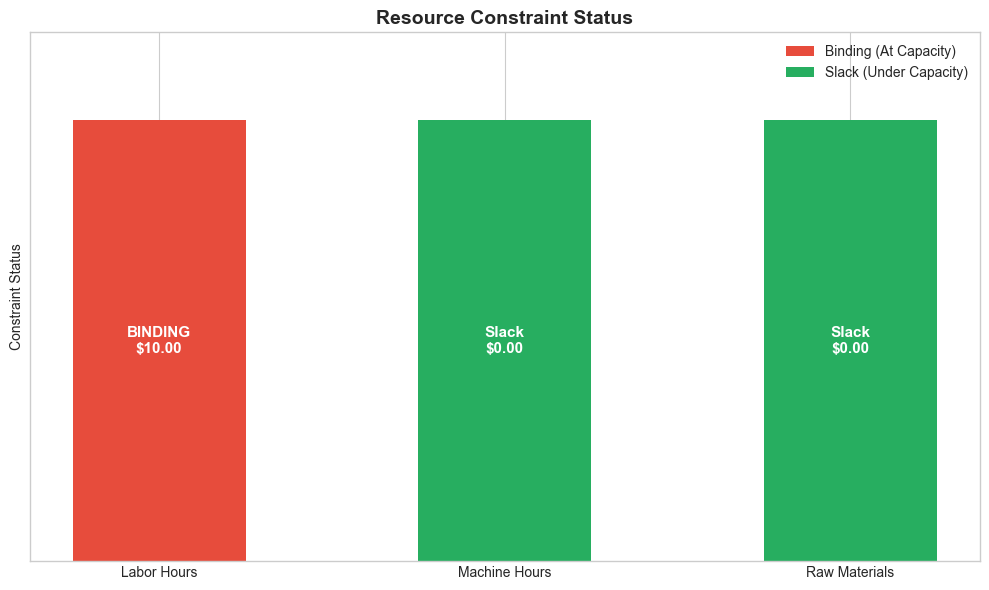

In [17]:
# Constraint status visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Gather all capacity constraints
constraint_data = []
for r in RESOURCES:
    sens = analyzer.analyze_constraint(f"capacity_{r.name}")
    constraint_data.append({
        'name': r.name,
        'binding': sens.is_binding,
        'shadow': sens.shadow_price if sens.shadow_price else 0
    })

# Create stacked bar showing binding vs slack
names = [c['name'] for c in constraint_data]
binding_values = [1 if c['binding'] else 0 for c in constraint_data]
slack_values = [0 if c['binding'] else 1 for c in constraint_data]

x = np.arange(len(names))
width = 0.5

ax.bar(x, binding_values, width, label='Binding (At Capacity)', color='#e74c3c')
ax.bar(x, slack_values, width, bottom=binding_values, label='Slack (Under Capacity)', color='#27ae60')

ax.set_ylabel('Constraint Status')
ax.set_title('Resource Constraint Status', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()
ax.set_ylim(0, 1.2)
ax.set_yticks([])

# Add shadow price annotations
for i, c in enumerate(constraint_data):
    status = "BINDING" if c['binding'] else "Slack"
    shadow = f"${c['shadow']:.2f}" if c['shadow'] > 0 else "$0.00"
    ax.text(i, 0.5, f"{status}\n{shadow}", ha='center', va='center', 
            fontsize=11, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

## 9. Business Recommendations

In [18]:
# Generate summary insights
print("="*60)
print("SENSITIVITY ANALYSIS SUMMARY")
print("="*60)
print(analyzer.generate_summary())

SENSITIVITY ANALYSIS SUMMARY
Sensitivity Summary
Binding constraints: 1
Bottlenecks (high shadow price): 1
Non-basic variables: 0

Top bottlenecks to address:
  • capacity_Labor Hours: shadow price = 10.0000
  • capacity_Machine Hours: shadow price = -0.0000
  • capacity_Raw Materials: shadow price = -0.0000


In [19]:
# Strategic recommendations
print("\n" + "="*60)
print("STRATEGIC RECOMMENDATIONS")
print("="*60)

print("\n1. RESOURCE INVESTMENT PRIORITIES:")
print("-"*40)

sorted_resources = sorted(shadow_prices, key=lambda x: x['Shadow Price'], reverse=True)
for i, r in enumerate(sorted_resources, 1):
    priority = "HIGH" if r['Shadow Price'] > 1 else "MEDIUM" if r['Shadow Price'] > 0.1 else "LOW"
    print(f"\n  {i}. {r['Resource']}")
    print(f"     Shadow Price: ${r['Shadow Price']:.2f}/unit")
    print(f"     Binding: {r['Binding']}")
    print(f"     Priority: [{priority}]")
    
    if r['Shadow Price'] > 0:
        print(f"     Recommendation: Consider expansion if cost < ${r['Shadow Price']:.2f}/unit")

print("\n2. BOTTLENECK MITIGATION:")
print("-"*40)

binding_count = sum(1 for r in shadow_prices if r['Binding'] == 'YES')
if binding_count >= 2:
    print("\n  ⚠ HIGH RISK: Multiple binding constraints")
    print("  - Solution is highly sensitive to parameter changes")
    print("  - Build buffer capacity or diversify resources")
elif binding_count == 1:
    print("\n  ⚡ MODERATE RISK: Single bottleneck")
    print("  - Focus on relaxing the binding constraint")
    print("  - Other resources have slack capacity")
else:
    print("\n  ✓ LOW RISK: No binding constraints")
    print("  - Solution is robust to small changes")

print("\n3. PRODUCTION FOCUS:")
print("-"*40)
print("\n  Most efficient products (profit/labor hour):")

efficiencies = [(p.name, (p.selling_price - p.unit_cost) / p.labor_hours) for p in PRODUCTS]
efficiencies.sort(key=lambda x: x[1], reverse=True)

for i, (name, eff) in enumerate(efficiencies[:3], 1):
    print(f"    {i}. {name}: ${eff:.2f}/labor hour")


STRATEGIC RECOMMENDATIONS

1. RESOURCE INVESTMENT PRIORITIES:
----------------------------------------

  1. Labor Hours
     Shadow Price: $10.00/unit
     Binding: YES
     Priority: [HIGH]
     Recommendation: Consider expansion if cost < $10.00/unit

  2. Machine Hours
     Shadow Price: $0.00/unit
     Binding: NO
     Priority: [LOW]

  3. Raw Materials
     Shadow Price: $0.00/unit
     Binding: NO
     Priority: [LOW]

2. BOTTLENECK MITIGATION:
----------------------------------------

  ⚡ MODERATE RISK: Single bottleneck
  - Focus on relaxing the binding constraint
  - Other resources have slack capacity

3. PRODUCTION FOCUS:
----------------------------------------

  Most efficient products (profit/labor hour):
    1. Widget A: $10.00/labor hour
    2. Widget B: $8.75/labor hour
    3. Gadget Y: $8.33/labor hour


## 10. Key Insights

### Shadow Prices
- **Definition**: Marginal value of relaxing a constraint by one unit
- **Use**: Prioritize resource investments based on shadow price magnitude
- **Validity**: Only valid within the allowable range (basis unchanged)

### Binding Constraints
- Constraints satisfied with equality at the optimum
- These are the bottlenecks limiting profitability
- Focus improvement efforts on binding constraints

### Reduced Costs
- Opportunity cost of forcing a non-basic variable into the solution
- Variables with zero reduced cost are in the optimal basis

### Business Application
1. **Investment decisions**: Invest in resources with high shadow prices
2. **Risk assessment**: More binding constraints = higher sensitivity
3. **Pricing decisions**: Shadow prices inform value of additional capacity

## 11. Extensions & Exercises

1. **Range analysis**: Compute allowable increases/decreases for RHS values
2. **Parametric analysis**: Plot objective vs constraint RHS
3. **Dual problem**: Solve the dual and verify complementary slackness
4. **Reduced cost analysis**: Investigate variables with high reduced costs
5. **Multi-period**: Extend to time-series sensitivity analysis